# RNNs

When introducing linear and logistic regression in Section 3 and Section 4 and multilayer perceptrons in Section 5, we were happy to assume that each feature vector 
 consisted of a fixed number of components 
, where each numerical feature 
 corresponded to a particular attribute. These datasets are sometimes called tabular, because they can be arranged in tables, where each example 
 gets its own row, and each attribute gets its own column. Crucially, with tabular data, we seldom assume any particular structure over the columns.

But what should we do when faced with a sequence of images, as in a video, or when tasked with producing a sequentially structured prediction, as in the case of image captioning?

Image captioning, speech synthesis, and music generation all require that models produce outputs consisting of sequences. In other domains, such as time series prediction, video analysis, and musical information retrieval, a model must learn from inputs that are sequences.

hese demands often arise simultaneously: tasks such as translating passages of text from one natural language to another, engaging in dialogue, or controlling a robot, demand that models both ingest and output sequentially-structured data.

ecurrent neural networks (RNNs) are deep learning models that capture the dynamics of sequences via recurrent connections, which can be thought of as cycles in the network of nodes.

Recurrent neural networks are unrolled across time steps (or sequence steps), with the same underlying parameters applied at each step. While the standard connections are applied synchronously to propagate each layer’s activations to the subsequent layer at the same time step, the recurrent connections are dynamic, passing information across adjacent time steps. As the unfolded view in Fig. 9.1 reveals, RNNs can be thought of as feedforward neural networks where each layer’s parameters (both conventional and recurrent) are shared across time steps.

------------- image of rnn unfolding ------------

One key insight paved the way for a revolution in sequence modeling. While the inputs and targets for many fundamental tasks in machine learning cannot easily be represented as fixed length vectors, they can often nevertheless be represented as varying-length sequences of fixed length vectors. For example, documents can be represented as sequences of words. Medical records can often be represented as sequences of events (encounters, medications, procedures, lab tests, diagnoses). Videos can be represented as varying-length sequences of still images.
While sequence models have popped up in countless application areas, basic research in the area has been driven predominantly by advances on core tasks in natural language processing. Thus, throughout this chapter, we will focus our exposition and examples on text data. If you get the hang of these examples, then applying these models to other data modalities should be relatively straightforward.

## Sequences

Up until now, we have focused on models whose inputs consisted of a single feature vector 
. The main change of perspective when developing models capable of processing sequences is that we now focus on inputs that consist of an ordered list of feature vectors 
, where each feature vector 
 indexed by a time step 
 lies in .

 Previously, when dealing with individual inputs, we assumed that they were sampled independently from the same underlying distribution 
. While we still assume that entire sequences (e.g., entire documents or patient trajectories) are sampled independently, we cannot assume that the data arriving at each time step are independent of each other. For example, what words are likely to appear later in a document depends heavily on what words occurred earlier in the document. What medicine a patient is likely to receive on the 10th day of a hospital visit depends heavily on what transpired in the previous nine days.

This should come as no surprise. If we did not believe that the elements in a sequence were related, we would not have bothered to model them as a sequence in the first place. Consider the usefulness of the auto-fill features that are popular on search tools and modern email clients. They are useful precisely because it is often possible to predict (imperfectly, but better than random guessing) what likely continuations of a sequence might be, given some initial prefix. For most sequence models, we do not require independence, or even stationarity, of our sequences. Instead, we require only that the sequences themselves are sampled from some fixed underlying distribution over entire sequences.

This flexible approach, allows for such phenomena as (i) documents looking significantly different at the beginning than at the end, or (ii) patient status evolving either towards recovery or towards death over the course of a hospital stay; and (iii) customer taste evolving in predictable ways over course of continued interaction with a recommender system.

We sometimes wish to predict a fixed target 
 given sequentially structured input (e.g., sentiment classification based on a movie review). At other times, we wish to predict a sequentially structured target (
) given a fixed input (e.g., image captioning). Still other times, our goal is to predict sequentially structured targets based on sequentially structured inputs (e.g., machine translation or video captioning). Such sequence-to-sequence tasks take two forms: (i) aligned: where the input at each time step aligns with a corresponding target (e.g., part of speech tagging); (ii) unaligned: where the input and target do not necessarily exhibit a step-for-step correspondence (e.g., machine translation).

we can tackle the most straightforward problem: unsupervised density modeling (also called sequence modeling). Here, given a collection of sequences, our goal is to estimate the probability mass function that tells us how likely we are to see any given sequence, i.e., 

https://theopavlakou.github.io/blog/density-estimation.html

### Autoregressive models

[pass the section again]

### Sequence models

#### Markove models

#### Decoding order

### Training

In [38]:
import torch
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
%matplotlib inline

In [16]:
# example training sample
T = 1000
t = torch.arange(1, T+1, dtype=torch.float32) # time
x = torch.sin(0.01*t) + 0.2 * torch.randn(T) # added some noise to sin distribution

In [39]:
def plot(x: torch.Tensor, y: torch.Tensor, xlabel: str, ylabel: str, figsize: tuple = (10, 5)):
    plt.figure(figsize=figsize)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

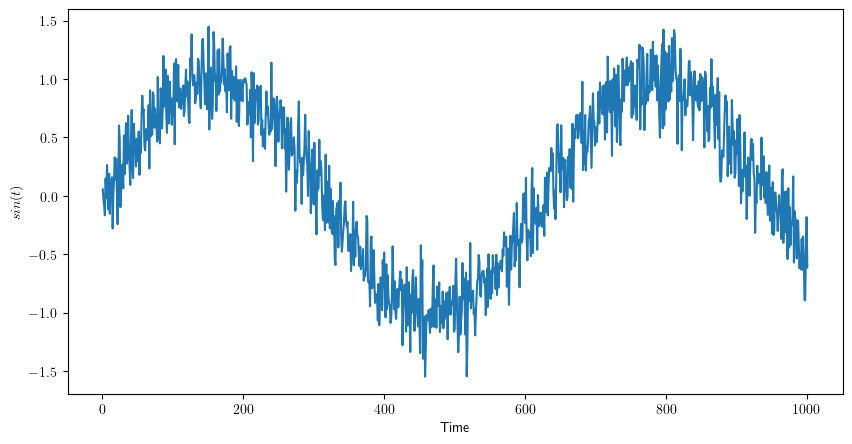

In [40]:
plot(t, x, "Time", "$sin(t)$")

In [55]:
tau = 4 # Markov order
num_train = 600
batch_size = 16

# get a set of features and labels, so that every i:i+4 x (features) corresponds to the i+5'th x (label),
# for i from 0 to T - 4
features = [x[i: T-tau+i] for i in range(tau)] # (4, 996)
features = torch.stack(features, 1) # (996, 4)
labels = x[tau:].reshape((-1, 1)) # (996, 1)

In [86]:
isTraining = True
# indices for training/validation
idx = slice(0, num_train) if isTraining else slice(num_train, None)

In [100]:
def tensor_dataloader(tensors: list[torch.Tensor], batch_size: int, \
                      isTraining: bool, indices: slice=slice(0, None)):
    tensors = tuple(t[indices] for t in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=isTraining)
    return dataloader

In [101]:
dl = tensor_dataloader([features, labels], batch_size, True, idx)
dl

In [62]:
labels = x[tau:].reshape((-1, 1))
np.shape(labels)

torch.Size([996, 1])

In [58]:
features

tensor([[ 0.0559, -0.0333, -0.0853, -0.1670],
        [-0.0333, -0.0853, -0.1670,  0.1485],
        [-0.0853, -0.1670,  0.1485, -0.0165],
        ...,
        [-0.3478, -0.5437, -0.8906, -0.8951],
        [-0.5437, -0.8906, -0.8951, -0.4568],
        [-0.8906, -0.8951, -0.4568, -0.1818]])

In [92]:
idx

slice(0, 600, None)

In [82]:
arr = np.arange(0, 10)

In [83]:
arr

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [84]:
arr[s]

array([2, 3, 4, 5, 6, 7, 8, 9])